In [20]:
import pandas as pd
import numpy as np

In [31]:
PROBLEM='p11_ga'
BENCHES=[ 'c8_1', 'c4_2' ]

In [32]:
dfs = []
for b in BENCHES:
    dfs.append(pd.read_csv('./'+PROBLEM+'/'+b+'.csv', names=["time", "objective"]))

In [10]:
dfs = [
    pd.read_csv(fname, names=['time', 'objective']) for fname in ['./p7_ga_c8_smaller.csv', './p7_ga_c4_smaller.csv']
]

In [11]:
dfs[0].time = dfs[0].time - dfs[0].at[0, 'time']
dfs[1].time = dfs[1].time - dfs[1].at[4, 'time']
dfs[1] = dfs[1][4:]

In [12]:
dfs[0].head(), dfs[1].head()

(        time    objective
 0   0.000000  2093.859569
 1   5.011853  2032.950359
 2  10.092351  2027.311474
 3  15.246164  2024.173392
 4  20.400748  2024.150211,
         time  objective
 4   0.000000  5705.9067
 5   5.004719  4548.0920
 6  10.007836  4113.0000
 7  15.015025  3386.2576
 8  20.019329  3147.6853)

In [13]:
dfs[0].head(), dfs[1].head()

(        time    objective
 0   0.000000  2093.859569
 1   5.011853  2032.950359
 2  10.092351  2027.311474
 3  15.246164  2024.173392
 4  20.400748  2024.150211,
         time  objective
 4   0.000000  5705.9067
 5   5.004719  4548.0920
 6  10.007836  4113.0000
 7  15.015025  3386.2576
 8  20.019329  3147.6853)

In [14]:
import matplotlib.pyplot as plt

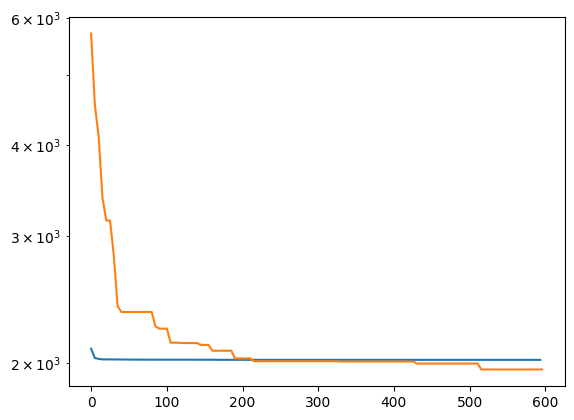

In [24]:
for df in dfs:
    plt.semilogy(df.time[:120], df.objective[:120])
plt.show()

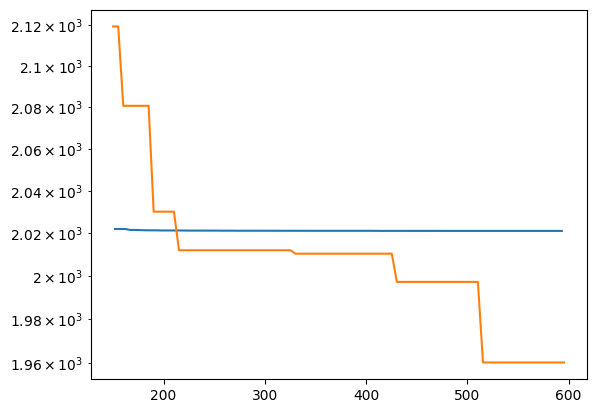

In [25]:
for df in dfs:
    plt.semilogy(df.time[30:120], df.objective[30:120])
plt.show()